# Projeto Final - Modelos preditivos - Dataset do Censo

## Grupo:
- Lucas Natan Correia Couri
- Mariama Celi Serafim de Oliveira
- Laianna Lana Virginio da Silva
- Priscilla Amarante de Lima
- Liviany Reis Rodrigues

# Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
from sklearn import model_selection
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
filterwarnings('ignore')

# Base de Dados

In [3]:
SEED = 6138
columns_name = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'class']
df = pd.read_csv("Dados/adult.data", names=columns_name, index_col=False)

In [4]:
df['native-country'].value_counts()

 United-States                 29170
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

# Análise Exploratória de Dados

explorar a base de dados para mostrar outliers, nivel de separatividade dos dados em relação as classes (grafico de dispersao), 

In [5]:
df.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


## Tipos dos dados

In [6]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
class             object
dtype: object

In [7]:
df['workclass'] = df['workclass'].astype('category')
df['education'] = df['education'].astype('category')
df['marital-status'] = df['marital-status'].astype('category')
df['occupation'] = df['occupation'].astype('category')
df['relationship'] = df['relationship'].astype('category')
df['race'] = df['race'].astype('category')
df['sex'] = df['sex'].astype('category')
df['native-country'] = df['native-country'].astype('category')
df['class'] = df['class'].astype('category')
df.dtypes

age                  int64
workclass         category
fnlwgt               int64
education         category
education-num        int64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         int64
capital-loss         int64
hours-per-week       int64
native-country    category
class             category
dtype: object

## Resolvendo o problema da Holanda

No dataset de treino há apenas uma obvservação como " Holand-Netherlands", diante do tamanho do dataset (mais de 30mil linhas) optou-se por remover essa única linha com native-country=" Holand-Netherlands" de forma a evitar problemas de ausência do valor no dataset de teste.

In [8]:
df = df[df['native-country']!=" Holand-Netherlands"]

## Descrição dos dados

In [9]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581849,1.897833e+05,10.080682,1077.681941,87.238790,40.437469
std,13.640593,1.055478e+05,2.572760,7385.403083,402.795459,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


## Dados duplicados

In [10]:
df.drop_duplicates(inplace = True)

In [11]:
df[df.duplicated()]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class


## Preenchendo dados faltantes

In [12]:
def tratamento_faltantes(df, columns_name):
    ## Printa os atributos com dados faltantes (" ?")
    for coluna in columns_name:
        if len(df[df[coluna] == " ?"]) > 0:
            print(coluna)
            print(len(df[df[coluna] == " ?"]))
    
    ## Tratamento dos dados faltantes, transforma para numerico, substitui " ?" por NaN e interpola os NaN
    atr_faltantes = ["workclass", "occupation", "native-country"]
    for atr in atr_faltantes:
        categorias_atr = df.groupby(atr).sum().index.tolist()
        label_encoder = preprocessing.LabelEncoder()
        label_encoder.fit(categorias_atr)
        df[f"{atr}-num"] = label_encoder.transform(df[atr])
        df[f"{atr}-num"] = df[f"{atr}-num"].replace(0, np.nan)
        df[f"{atr}-num"] = df[f"{atr}-num"].interpolate(method='nearest')

In [13]:
tratamento_faltantes(df, columns_name)

workclass
1836
occupation
1843
native-country
582


In [14]:
#for coluna in columns_name:
#    if len(df[df[coluna] == " ?"]) > 0:
#        print(coluna)
#        print(len(df[df[coluna] == " ?"]))

Para cada atributo que tem dados faltantes vamos preencher utilizando a interpolação, para isso passamos para numerico antes.

In [15]:
#atr_faltantes = ["workclass", "occupation", "native-country"]
#for atr in atr_faltantes:
#    categorias_atr = df.groupby(atr).sum().index.tolist()
#    label_encoder = preprocessing.LabelEncoder()
#    label_encoder.fit(categorias_atr)
#    df[f"{atr}-num"] = label_encoder.transform(df[atr])
#    df[f"{atr}-num"] = df[f"{atr}-num"].replace(0, np.nan)
#    df[f"{atr}-num"] = df[f"{atr}-num"].interpolate(method='nearest')

In [16]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,workclass-num,occupation-num,native-country-num
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,7.0,1.0,39.0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,6.0,4.0,39.0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,4.0,6.0,39.0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,4.0,6.0,39.0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,4.0,10.0,5.0


## Checando outliers

<AxesSubplot:>

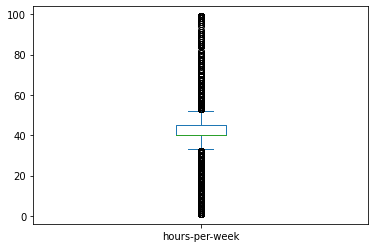

In [17]:
df['hours-per-week'].plot.box()

<AxesSubplot:>

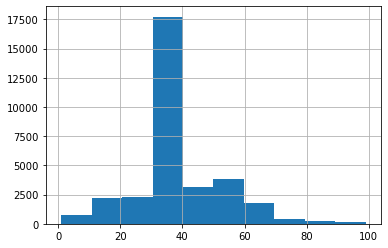

In [18]:
df['hours-per-week'].hist()

<AxesSubplot:>

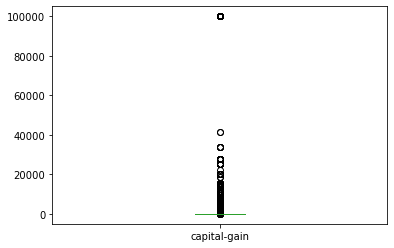

In [19]:
df['capital-gain'].plot.box()

<AxesSubplot:>

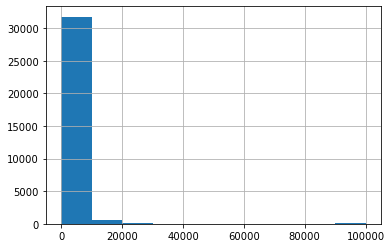

In [20]:
df['capital-gain'].hist()

<AxesSubplot:>

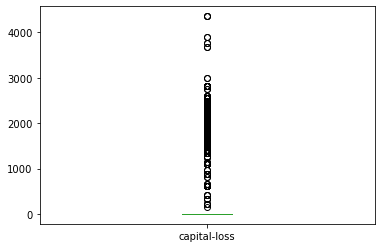

In [21]:
df['capital-loss'].plot.box()

<AxesSubplot:>

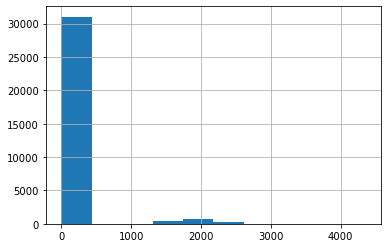

In [22]:
df['capital-loss'].hist()

In [23]:
#q1 = dados['idade_log'].quantile(q=0.25)
#q3 = dados['idade_log'].quantile(q=0.75)
#iqr = q3 - q1
#print(iqr)

## Colunas redundantes

In [24]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,workclass-num,occupation-num,native-country-num
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,7.0,1.0,39.0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,6.0,4.0,39.0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,4.0,6.0,39.0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,4.0,6.0,39.0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,4.0,10.0,5.0


education e education-num significam a mesma coisa, vamos utilizar education-num e dropar education (education-num já é a codificação ordinal de education)

In [25]:
df['education'].value_counts()

 HS-grad         10494
 Some-college     7281
 Bachelors        5353
 Masters          1722
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           645
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           332
 1st-4th           166
 Preschool          50
Name: education, dtype: int64

In [26]:
df['education-num'].value_counts()

9     10494
10     7281
13     5353
14     1722
11     1382
7      1175
12     1067
6       933
4       645
15      576
5       514
8       433
16      413
3       332
2       166
1        50
Name: education-num, dtype: int64

## TO DO: Plotar região

## Frequência das variáveis categóricas (Value counts)

In [27]:
df['workclass'].value_counts()

 Private             22672
 Self-emp-not-inc     2540
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

In [28]:
df['education'].value_counts()

 HS-grad         10494
 Some-college     7281
 Bachelors        5353
 Masters          1722
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           645
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           332
 1st-4th           166
 Preschool          50
Name: education, dtype: int64

In [29]:
df['marital-status'].value_counts()

 Married-civ-spouse       14970
 Never-married            10666
 Divorced                  4441
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64

In [30]:
df['occupation'].value_counts()

 Prof-specialty       4136
 Craft-repair         4094
 Exec-managerial      4065
 Adm-clerical         3768
 Sales                3650
 Other-service        3291
 Machine-op-inspct    1999
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1369
 Farming-fishing       992
 Tech-support          927
 Protective-serv       649
 Priv-house-serv       147
 Armed-Forces            9
Name: occupation, dtype: int64

In [31]:
df['relationship'].value_counts()

 Husband           13187
 Not-in-family      8292
 Own-child          5064
 Unmarried          3445
 Wife               1568
 Other-relative      980
Name: relationship, dtype: int64

In [32]:
df['race'].value_counts()

 White                 27794
 Black                  3122
 Asian-Pac-Islander     1038
 Amer-Indian-Eskimo      311
 Other                   271
Name: race, dtype: int64

In [33]:
df['sex'].value_counts()

 Male      21775
 Female    10761
Name: sex, dtype: int64

In [34]:
df['native-country'].value_counts()

 United-States                 29153
 Mexico                          639
 ?                               582
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        62
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

In [35]:
df['class'].value_counts()

 <=50K    24697
 >50K      7839
Name: class, dtype: int64

In [36]:
# df_test['class'].value_counts()

# Carregando e processando conjunto de teste

In [37]:
df_test = pd.read_csv("Dados/adult.test", names=columns_name, index_col=False, skiprows=1)
df_test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [38]:
tratamento_faltantes(df_test, columns_name)

workclass
963
occupation
966
native-country
274


## Codificação das variáveis categóricas (variáveis nominais, faremos One Hot Encoder)

In [39]:
def onehot_encoder(df):
    colunas_cat = ["workclass-num","marital-status", "occupation-num", "relationship", "race", "sex", "native-country-num"]
    for coluna in colunas_cat:
        print(coluna)
        df_coluna = pd.get_dummies(df[coluna], prefix=coluna)
        df = df.join(df_coluna)
    return df

In [40]:
df = onehot_encoder(df)
df.head()

workclass-num
marital-status
occupation-num
relationship
race
sex
native-country-num


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,native-country-num_32.0,native-country-num_33.0,native-country-num_34.0,native-country-num_35.0,native-country-num_36.0,native-country-num_37.0,native-country-num_38.0,native-country-num_39.0,native-country-num_40.0,native-country-num_41.0
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,...,0,0,0,0,0,0,0,1,0,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,0,0,0,0,0,0,0,1,0,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,...,0,0,0,0,0,0,0,1,0,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,...,0,0,0,0,0,0,0,1,0,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df_test = onehot_encoder(df_test)
df_test.head()

workclass-num
marital-status
occupation-num
relationship
race
sex
native-country-num


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,native-country-num_31.0,native-country-num_32.0,native-country-num_33.0,native-country-num_34.0,native-country-num_35.0,native-country-num_36.0,native-country-num_37.0,native-country-num_38.0,native-country-num_39.0,native-country-num_40.0
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,...,0,0,0,0,0,0,0,1,0,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,...,0,0,0,0,0,0,0,1,0,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,...,0,0,0,0,0,0,0,1,0,0
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,...,0,0,0,0,0,0,0,1,0,0
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,...,0,0,0,0,0,0,0,1,0,0


## Normalizando variáveis contínuas

In [42]:
from sklearn.preprocessing import MinMaxScaler

normalize = MinMaxScaler()
df[["age", "fnlwgt", "capital-gain", "capital-loss", "hours-per-week", "education-num"]] = normalize.fit_transform(df[["age", "fnlwgt", "capital-gain", "capital-loss", "hours-per-week", "education-num"]])
df_test[["age", "fnlwgt", "capital-gain", "capital-loss", "hours-per-week", "education-num"]] = normalize.fit_transform(df_test[["age", "fnlwgt", "capital-gain", "capital-loss", "hours-per-week", "education-num"]])

In [43]:
df[["age", "fnlwgt", "capital-gain", "capital-loss", "hours-per-week", "education-num"]]

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,education-num
0,0.301370,0.044302,0.021740,0.0,0.397959,0.800000
1,0.452055,0.048238,0.000000,0.0,0.122449,0.800000
2,0.287671,0.138113,0.000000,0.0,0.397959,0.533333
3,0.493151,0.151068,0.000000,0.0,0.397959,0.400000
4,0.150685,0.221488,0.000000,0.0,0.397959,0.800000
...,...,...,...,...,...,...
32556,0.136986,0.166404,0.000000,0.0,0.377551,0.733333
32557,0.315068,0.096500,0.000000,0.0,0.397959,0.533333
32558,0.561644,0.094827,0.000000,0.0,0.397959,0.533333
32559,0.068493,0.128499,0.000000,0.0,0.193878,0.533333


## Dividindo conjuntos de dados

In [44]:
X_train = df.drop(["class", "education", "workclass", "workclass-num","marital-status", "occupation", "occupation-num", "relationship", "race", "sex", "native-country", "native-country-num"], axis = 1).to_numpy()
y_train = df["class"].values
X_test = df_test.drop(["class", "education", "workclass", "workclass-num","marital-status", "occupation", "occupation-num", "relationship", "race", "sex", "native-country", "native-country-num"], axis = 1).to_numpy()
y_test = df_test["class"].values

In [45]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [46]:
df.drop(["class", "education", "workclass", "workclass-num","marital-status", "occupation", "occupation-num", "relationship", "race", "sex", "native-country", "native-country-num"], axis = 1)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass-num_1.0,workclass-num_2.0,workclass-num_3.0,workclass-num_4.0,...,native-country-num_32.0,native-country-num_33.0,native-country-num_34.0,native-country-num_35.0,native-country-num_36.0,native-country-num_37.0,native-country-num_38.0,native-country-num_39.0,native-country-num_40.0,native-country-num_41.0
0,0.301370,0.044302,0.800000,0.021740,0.0,0.397959,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.048238,0.800000,0.000000,0.0,0.122449,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.138113,0.533333,0.000000,0.0,0.397959,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0.493151,0.151068,0.400000,0.000000,0.0,0.397959,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0.150685,0.221488,0.800000,0.000000,0.0,0.397959,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,0.166404,0.733333,0.000000,0.0,0.377551,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
32557,0.315068,0.096500,0.533333,0.000000,0.0,0.397959,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
32558,0.561644,0.094827,0.533333,0.000000,0.0,0.397959,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
32559,0.068493,0.128499,0.533333,0.000000,0.0,0.193878,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


# Testando validação

In [47]:
#7. Realizar busca com o gridsearch ou randonsearhc para encontrar os melhores parametros de cada modelo
# define models
decisionTree = DecisionTreeClassifier()
#svc = SVC()

# define evaluation
cv = model_selection.StratifiedKFold(n_splits=10)

# define search space for decision tree
space = dict()
space['criterion'] = ['gini', 'entropy']
space['min_samples_split'] = [2,3,5,7]
space['max_depth'] = [3,5,6,7,9,11,13,15,17,19]
space['min_samples_leaf'] = [2, 3]


# define random search for decision tree
search = RandomizedSearchCV(decisionTree, space, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=SEED)

# execute search
result_tree = search.fit(X_train, y_train)

# summarize result for decision tree
print('=========Random Search Results for TREE==========')
print('Best Score: %s' % result_tree.best_score_)
print('Best Hyperparameters: %s' % result_tree.best_params_)

=========Random Search Results for TREE==========
Best Score: 0.8562825747723581
Best Hyperparameters: {'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 11, 'criterion': 'entropy'}


In [48]:
decisionTree = DecisionTreeClassifier(**result_tree.best_params_, random_state=SEED)

result_tree = decisionTree.fit(X_train, y_train)

print(classification_report(y_test, decisionTree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     12435
           1       0.75      0.53      0.62      3846

    accuracy                           0.85     16281
   macro avg       0.81      0.74      0.76     16281
weighted avg       0.84      0.85      0.84     16281



# KNN (Livy)

# Árvore de decisão simples (Priscilla)

In [49]:
from sklearn.model_selection import GridSearchCV
# define models
decisionTree = DecisionTreeClassifier()

# define evaluation
cv = model_selection.StratifiedKFold(n_splits=10)

# define search space for decision tree
space = dict()
space['criterion'] = ['gini', 'entropy']
space['min_samples_split'] = [2,15,5,22]
space['max_depth'] = range(1,60)
space['min_samples_leaf'] = [2, 6]


# define random search for decision tree
search = RandomizedSearchCV(decisionTree, space, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=SEED)
#search = GridSearchCV(decisionTree, space, scoring='accuracy', n_jobs=-1, cv=cv, verbose=4)


# execute search
result_tree = search.fit(X_train, y_train)

# summarize result for decision tree
print('=========Random Search Results for TREE==========')
print('Best Score: %s' % result_tree.best_score_)
print('Best Hyperparameters: %s' % result_tree.best_params_)

=========Random Search Results for TREE==========
Best Score: 0.8556679938578752
Best Hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 6, 'max_depth': 10, 'criterion': 'entropy'}


In [54]:
from sklearn.model_selection import GridSearchCV
# define models
decisionTree = DecisionTreeClassifier()

# define evaluation
cv = model_selection.StratifiedKFold(n_splits=10)

# define search space for decision tree
space = dict()
space['criterion'] = ['gini', 'entropy']
space['min_samples_split'] = [1,4,5,9]
space['max_depth'] = range(8,13)
space['min_samples_leaf'] = [4,10]


# define random search for decision tree
search = RandomizedSearchCV(decisionTree, space, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=SEED)
#search = GridSearchCV(decisionTree, space, scoring='accuracy', n_jobs=-1, cv=cv, verbose=4)


# execute search
result_tree = search.fit(X_train, y_train)

# summarize result for decision tree
print('=========Random Search Results for TREE==========')
print('Best Score: %s' % result_tree.best_score_)
print('Best Hyperparameters: %s' % result_tree.best_params_)

=========Random Search Results for TREE==========
Best Score: 0.8574812791596467
Best Hyperparameters: {'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 10, 'criterion': 'gini'}


In [50]:
#instanciando
tree_classifier = DecisionTreeClassifier(criterion='entropy', max_depth= 11, min_samples_leaf= 3, min_samples_split= 7, random_state=SEED)
model = tree_classifier.fit(X_train, y_train)

In [51]:
text_representation = tree.export_text(tree_classifier)
print(text_representation)

|--- feature_16 <= 0.50
|   |--- feature_3 <= 0.07
|   |   |--- feature_2 <= 0.77
|   |   |   |--- feature_0 <= 0.16
|   |   |   |   |--- feature_0 <= 0.06
|   |   |   |   |   |--- feature_2 <= 0.23
|   |   |   |   |   |   |--- feature_5 <= 0.58
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_5 >  0.58
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_2 >  0.23
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_0 >  0.06
|   |   |   |   |   |--- feature_4 <= 0.51
|   |   |   |   |   |   |--- feature_5 <= 0.49
|   |   |   |   |   |   |   |--- feature_15 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_1 <= 0.01
|   |   |   |   |   |   |   |   |   |--- feature_1 <= 0.01
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- feature_1 >  0.01
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_1 >  0.01
|   |   |   |   |   |   |

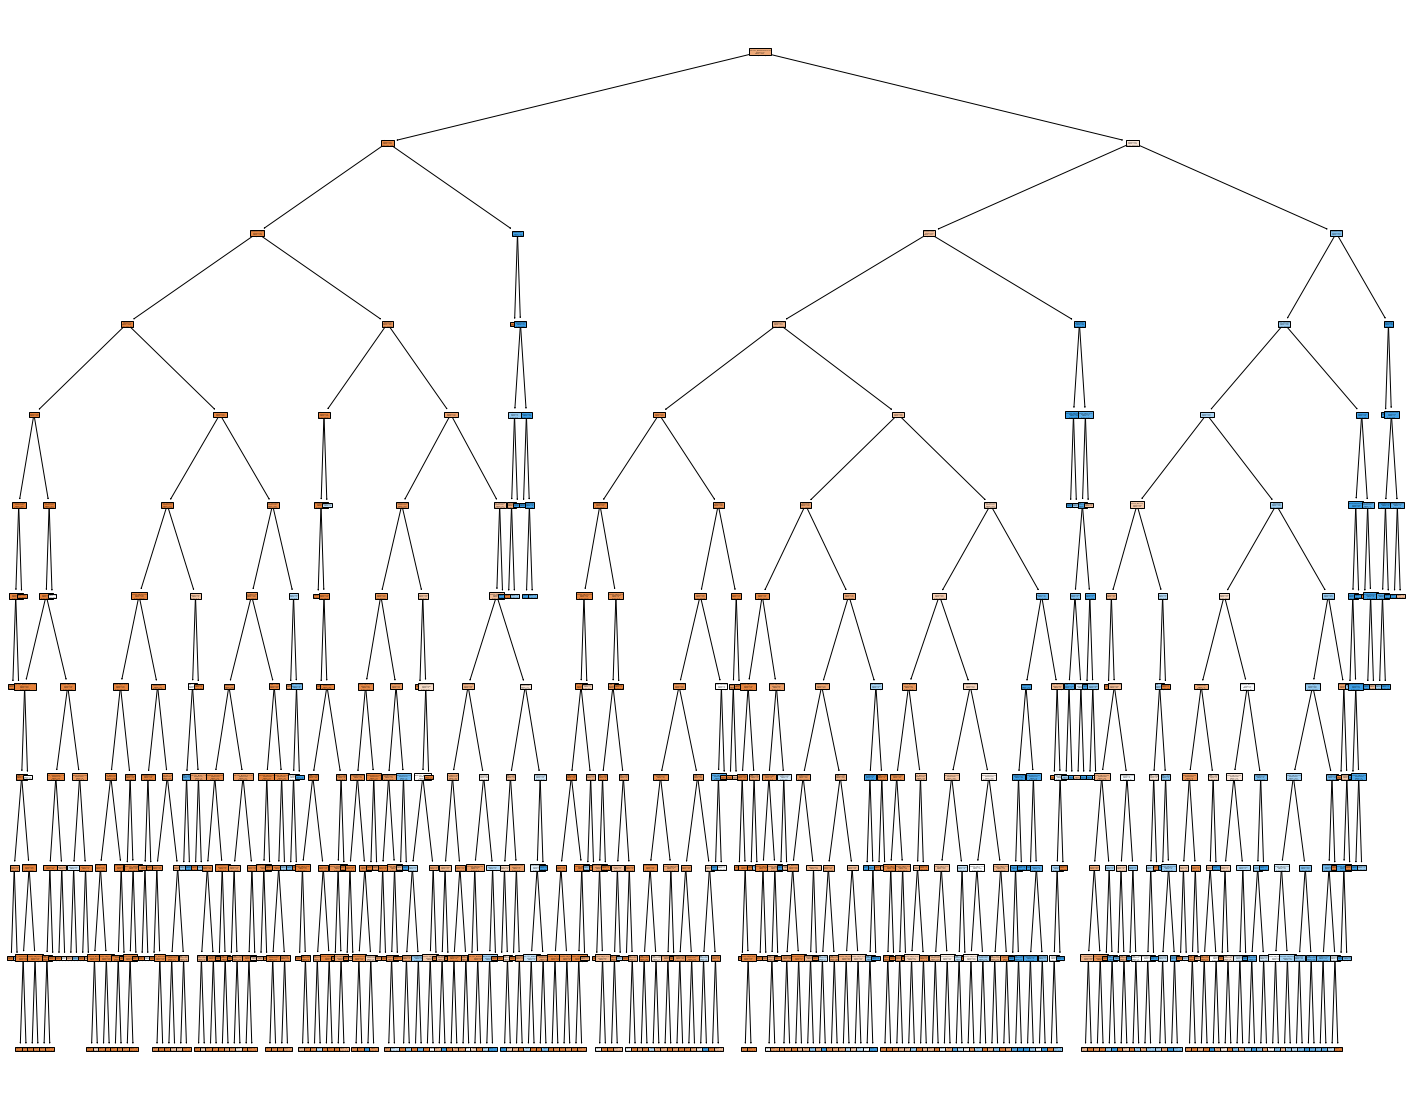

In [52]:
#plotar a melhor árvore
feature_names=df.drop(["class", "education", "workclass", "workclass-num","marital-status", "occupation", "occupation-num", "relationship", "race", "sex", "native-country", "native-country-num"], axis = 1).columns

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_classifier, 
                   feature_names=feature_names,  
                  #  class_names=list(label_encoder.classes_),
                   filled=True)

# Random Forest (Lucas)

In [ ]:
from sklearn.model_selection import GridSearchCV

def search_rf(parameters, cv, X_train, y_train, SEED):

    grid_search = GridSearchCV(RandomForestClassifier(random_state=SEED), 
                        parameters,
                        scoring  = "accuracy",
                        n_jobs= -1, 
                        verbose=4,
                        cv = cv)

    grid_search.fit(X_train, y_train)

    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    print(best_params)
    print(best_score)
    return best_params


## Tentativa 1 (18min)

In [ ]:
parameters = {
    "n_estimators": range(10, 301, 20),
    "criterion": ["gini", "entropy"],
    "max_features": ["auto", "sqrt", "log2"],
}

rf_try1 = search_rf(parameters, cv, X_train, y_train, SEED)

## Tentativa 2 (47min)

In [ ]:
parameters = {
    "n_estimators": range(300, 451, 10),
    "criterion": ["gini", "entropy"],
    "max_features": ["auto", "sqrt", "log2"],
}

rf_try2 = search_rf(parameters, cv, X_train, y_train, SEED)

## Tentativa 3 (17min)

In [ ]:
parameters = {
    "n_estimators": range(408, 413, 1),
    "criterion": ["gini", "entropy"],
    "max_features": ["auto", "sqrt", "log2"],
}

rf_try3 = search_rf(parameters, cv, X_train, y_train, SEED)

## Tentativa 4

In [ ]:
parameters = {
    "n_estimators": [190,440,412],#range(407, 412, 1),
    "criterion": ["gini", "entropy"],
    "max_features": ["auto", "sqrt", "log2"],
    'min_samples_leaf': [1, 4],
    'min_samples_split': [2, 10]#,
    #'max_depth': [10, 100, None]#[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
}

rf_try4 = search_rf(parameters, cv, X_train, y_train, SEED)

## Desempenho no teste

In [ ]:
#{'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 440}
best_rf = RandomForestClassifier(**rf_try4, random_state = SEED)
best_rf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
print("Score de teste:", accuracy_score(y_test, best_rf.predict(X_test)))

# Rede neural MLP (Mari)

In [ ]:
cv = model_selection.StratifiedKFold(n_splits=10)

def gridsearch_mlp(X_train, y_train, parameters, metric, seed = SEED):
    search = GridSearchCV(MLPClassifier(random_state = seed), parameters, scoring=metric,  n_jobs=-1, cv=cv, return_train_score=True, verbose=10)

    result_mlp = search.fit(X_train, y_train)
    print_result(result_mlp)
    return result_mlp


def randomsearch_mlp(X_train, y_train, parameters, metric, seed = SEED):
    search = RandomizedSearchCV(MLPClassifier(random_state = seed), parameters, n_iter=100, n_jobs=-1, scoring=metric, cv=cv, random_state=seed, return_train_score=True, verbose=10)

    result_mlp = search.fit(X_train, y_train)
    print_result(result_mlp)
    return result_mlp


def print_result(result): 
    # summarize result 
    print('=========Random Search Results for MLP==========')
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_) 


### Tentativa 1 (55 min)

In [ ]:
# define search space for MPL
space = dict()
space["hidden_layer_sizes"] = [(4,4), (20,15),(50,50), (100,50), (50,100), (100, 250),(4,10,4),(20,10,5),(250, 100, 50)]
space["activation"] = ["logistic", "tanh", "relu", "identity"]
space["solver"] = ["lbfgs", "sgd", "adam"]

result1 = randomsearch_mlp(X_train, y_train, space, "accuracy")


In [ ]:
results = pd.DataFrame(result1.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.head(10)

### Tentativa 2

In [ ]:
#Adicionando leaning_rate e retirando algumas opções
space = dict()
space["hidden_layer_sizes"] = [(4,4), (20,15),(50,50), (100,50), (50,100), (100, 250),(4,10,4),(20,10,5),(250, 100, 50)]
space["activation"] = ["logistic", "tanh", "relu"]
space["solver"] = ["lbfgs", "adam"]
space["learning_rate"] = ["constant", "invscaling", "adaptive"] 

result2 = gridsearch_mlp(X_train, y_train, space, "accuracy")


In [ ]:
results = pd.DataFrame(result2.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.head(10)

### Tentativa 3

In [ ]:
#Variando camadas e retirando alguns valores
space = dict()
space["hidden_layer_sizes"] = [(50,30,20,10),(20,15),(20,20,20,20),(100, 250),(100, 250, 300,450),(250, 100, 50)]
space["activation"] = ["tanh"]
space["solver"] = ["lbfgs"]
space["learning_rate"] = ["constant", "invscaling", "adaptive"] 

result3 = gridsearch_mlp(X_train, y_train, space, "accuracy")

### Tentativa 4

In [ ]:
#Variando camadas e retirando alguns valores
space = dict()
space["hidden_layer_sizes"] = [(5,5,5,5),(10,10,10,10),(50,50,50,50),(10,10,10,10,10)]
space["activation"] = ["logistic", "tanh"]
space["solver"] = ["lbfgs"]

space["learning_rate"] = ["constant", "invscaling", "adaptive"] 

result4 = gridsearch_mlp(X_train, y_train, space, "accuracy")

# Comitê de Redes Neurais

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
mlp = MLPClassifier(random_state = SEED)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred))
print("\n")
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
def val_bgc(X_test, y_test, X_train, y_train, SEED, num_e, hidden_l, max_iterations, max_samples):

    parameters = {
        "n_estimators": num_e,
        "max_samples": max_samples
    }
    
    gs_bgc_mlp = GridSearchCV(BaggingClassifier(MLPClassifier(hidden_layer_sizes = hidden_l,
                                                              max_iter = max_iterations,
                                                              random_state = SEED)),
                              parameters,
                              scoring = "accuracy",
                              #cv = cv,
                              n_jobs= -1
                             )

    gs_bgc_mlp.fit(X_train, y_train)
    
    gs_bgc_mlp.fit(X_train, y_train)

    best_params = gs_bgc_mlp.best_params_

    return best_params, gs_bgc_mlp

In [ ]:
hidden_l = (10, 10)
max_iterations = 200
num_e = [10, 20]
max_samples = [1000, 50]

best_params, gs_bgc_mlp = val_bgc(X_test, y_test, X_train, y_train, SEED, num_e, hidden_l, max_iterations, max_samples)

In [ ]:
print(best_params)
means = gs_bgc_mlp.cv_results_["mean_test_score"]
stds = gs_bgc_mlp.cv_results_["std_test_score"]

for mean, std, params in zip(means, stds, gs_bgc_mlp.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [ ]:
y_pred = gs_bgc_mlp.predict(X_test)

print(classification_report(y_test, y_pred))

# Comitê Heterogêneo